# Process images by grayscale inversion

In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

## Test on one image

In [62]:
img_path = "/data_ETIS/SWI/2018-104_01-10165-D0MR_13_T2_EG_AX_fl2d1r.nii.gz"
img = nib.load(img_path)

In [3]:
img.shape

(480, 640, 80)

In [5]:
img.get_data_dtype()

dtype('<i2')

In [63]:
data = img.get_fdata()

(array([1.8191748e+07, 1.9163580e+06, 4.2314850e+06, 2.3217800e+05,
        2.9030000e+03, 7.8900000e+02, 3.6200000e+02, 1.4300000e+02,
        3.0000000e+01, 4.0000000e+00]),
 array([  0. ,  61.3, 122.6, 183.9, 245.2, 306.5, 367.8, 429.1, 490.4,
        551.7, 613. ]),
 <BarContainer object of 10 artists>)

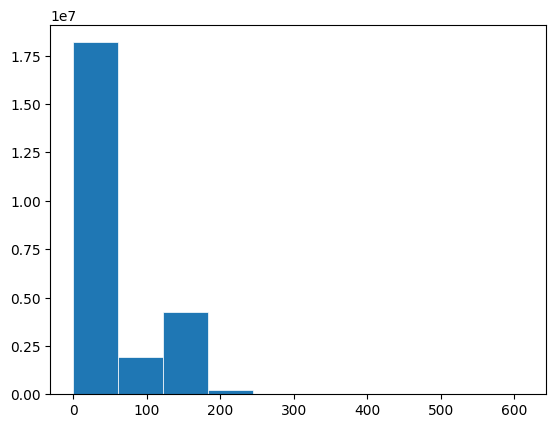

In [7]:
fig, ax = plt.subplots()

ax.hist(data.flatten(), linewidth=0.5, edgecolor="white")

In [13]:
np.max(data)

613.0

In [18]:
np.histogram(data.flatten(), bins=5)

(array([20108106,  4463663,     3692,      505,       34], dtype=int64),
 array([  0. , 122.6, 245.2, 367.8, 490.4, 613. ]))

In [14]:
print(img.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 54
dim             : [  3 480 640  80   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.       0.359375 0.359375 2.       0.026    0.       0.       0.      ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'TE=20;Time=143916.013'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : -0.06872057
quatern_c       : 0.011157925
quatern_d       : 0.02319331
qoffset_x       : -85.52739


In [2]:
def invert_grayscale(array, max_quantile_cutoff=1.0, final_dtype=np.int16):
    #Invert the pixel values using max_quantile_cutoff as the quantile of the boundary value. Values greater than the boundary will be treated equal to the boundary in the next step.
    negated_array = np.quantile(array.flatten(), max_quantile_cutoff).astype(final_dtype) + np.negative(array).astype(final_dtype)
    
    #Round out values greater than the boundary value
    return np.maximum(np.zeros(array.shape, dtype=final_dtype), negated_array)

In [3]:
def save_array_to_nifti1(array, original_img, destination_path, output_name):
    processed_img = nib.Nifti1Image(array, original_img.affine)
    nib.save(processed_img, os.path.join(destination_path, output_name))

In [67]:
save_array_to_nifti1(invert_grayscale(data, 0.99), img, os.getcwd(), "2018-104_01-10165-D0MR_13_T2_EG_AX_fl2d1r_Inverted_999.nii.gz")

In [25]:
processed_img = nib.Nifti1Image(invert_grayscale(data, 0.99), img.affine)

## Analyze image histograms

In [1]:
def compute_img_histograms (source_path, histogram_bins, files_to_process=None):
    files = os.listdir(source_path)
    
    if files_to_process is None:
        nifti_files = [file for file in files if file.endswith('.nii.gz')]
    else:
        nifti_files = [file for file in files if file.endswith('.nii.gz')][:files_to_process]

    histogram_list = []

    for file in nifti_files:
        file_path = os.path.join(source_path, file)
        nii_img = nib.load(file_path)
        nii_data = nii_img.get_fdata()
        histogram_list.append(np.histogram(nii_data.flatten(), bins=histogram_bins))
    
    return histogram_list

In [17]:
hist_list = compute_img_histograms("/data_ETIS/SWI/", 5)

In [45]:
hist_list[15]

(array([5533761, 1645433,  159689,    1056,      93], dtype=int64),
 array([  0. , 114.8, 229.6, 344.4, 459.2, 574. ]))

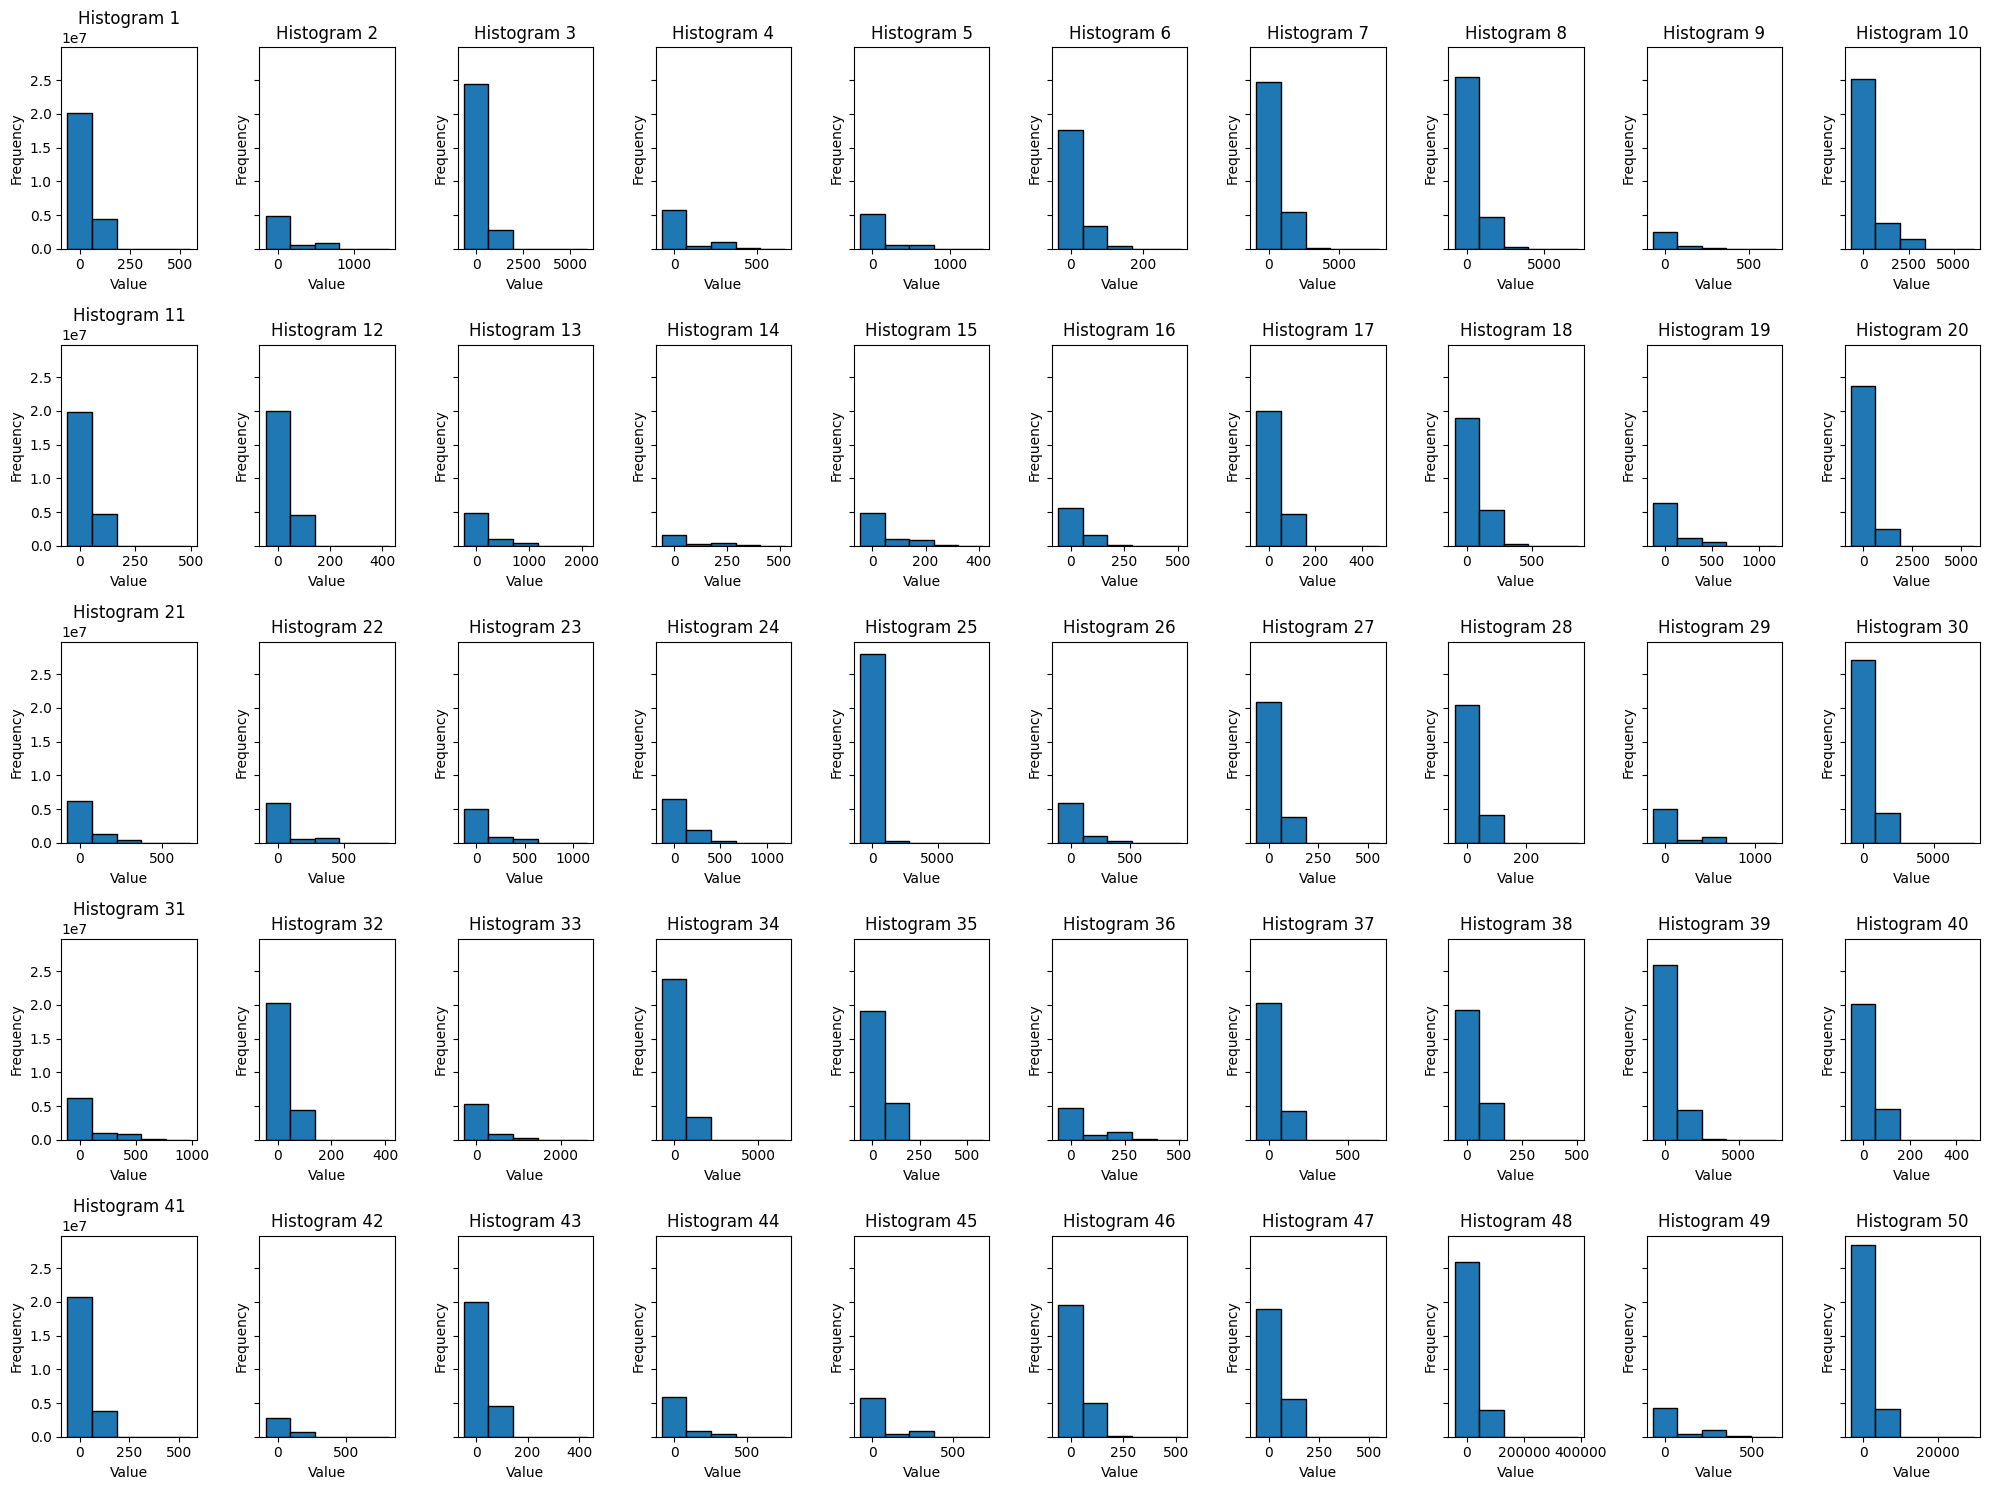

In [39]:
fig, axs = plt.subplots(5, 10, figsize=(20, 15), sharey=True)

axs = axs.flatten()

for i, hist_data in list(enumerate(hist_list))[:50]:
    counts, bins = hist_data
    
    # Compute histogram
    axs[i].bar(bins[:-1], counts, width=np.diff(bins), edgecolor='black')
    
    # Customize histogram appearance
    axs[i].set_title(f'Histogram {i+1}')
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

## Process Folder

In [12]:
def apply_processing_to_img_folder (processing_function, source_path, destination_path, modification_string, inclusion_string="", **kwargs):
    files = os.listdir(source_path)
    nifti_files = [file for file in files if (file.endswith('.nii.gz')) & (inclusion_string in file)]

    for file in nifti_files:
        file_path = os.path.join(source_path, file)
        nii_img = nib.load(file_path)
        nii_data = nii_img.get_fdata()
        new_img_name = os.path.splitext(os.path.splitext(file)[0])[0] + "_" + modification_string + ".nii.gz"
        save_array_to_nifti1(processing_function(nii_data, **kwargs), nii_img, destination_path, new_img_name)
        print("Processed image ", file)

In [14]:
basedir = "D:\\ADS_Inference\\Original_ADS"
folder_list = [folder for folder in os.listdir(basedir) if (".ipynb" not in folder) ]

for folder in folder_list:
    folder_path = os.path.join(basedir, folder)
    apply_processing_to_img_folder(invert_grayscale, folder_path, folder_path, "", "Normalized_DWI", max_quantile_cutoff=0.99)

Processed image  2018-104_01-10087-D0MR_Normalized_DWI.nii.gz
Processed image  2018-104_01-10087-D0MR_Normalized_DWI_MNI.nii.gz
Processed image  2018-104_01-10087-D0MR_Normalized_DWI_Norm_MNI.nii.gz
Processed image  2018-104_01-10113-D0MR_Normalized_DWI.nii.gz
Processed image  2018-104_01-10114-D0MR_Normalized_DWI.nii.gz
Processed image  2018-104_01-10116-D0MR_Normalized_DWI.nii.gz
Processed image  2018-104_01-10117-D0MR_Normalized_DWI.nii.gz
Processed image  2018-104_01-10118-D0MR_Normalized_DWI.nii.gz
